# Googlebot log file analysis
by [@tomdonohoe](https://au.linkedin.com/in/tomdonohoe)

This report provides analysis on the Search section server log files of allhomes.com.au web property for the month of July 2019.

## The dataset

The dataset includes 4,497,422 and 6 columns:

- **date:** date of the request.
- **client_ip:** the ip address of requesting client.
- **http_status_code:** the HTTP status code response of the request.
- **user_agent:** the user agent of the request.
- **path:** the url path that was requested.

## Read and clean dataset

First the dataset must be put into a DataFrame and cleaned up for analysis.

### import the required packages

In [51]:
import helper_funcs as hf
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline 

Set CSV location as variable

In [52]:
log_file_csv = 'data/processed_log_file.csv'

Read the CSV into a DataFrame

In [53]:
raw_logs = pd.read_csv(log_file_csv)

### Basic exploration

Take a quick look to get a feel for the data.

In [54]:
raw_logs.head()

,DATE,CLIENT_IP,HTTP_STATUS_CODE,USER_AGENT,PATH,is_verified_googlebot
0,2019-07-02 00:00:00,66.249.79.145,200,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,/rent/turvey-park-nsw-2650/,True
1,2019-07-02 00:00:00,66.249.79.137,200,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,/share/tanunda-sa-5352/,True
2,2019-07-02 00:00:00,66.249.79.158,200,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,/sale/strathfieldsaye-vic-3551/,True
3,2019-07-02 00:00:00,66.249.79.131,200,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,/rent/glenore-grove-qld-4342/,True
4,2019-07-02 00:00:00,66.249.79.145,200,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,/sale/bullsbrook-wa-6084/,True


In [55]:
raw_logs.shape

(4497422, 6)

In [56]:
raw_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4497422 entries, 0 to 4497421
Data columns (total 6 columns):
DATE                     object
CLIENT_IP                object
HTTP_STATUS_CODE         int64
USER_AGENT               object
PATH                     object
is_verified_googlebot    bool
dtypes: bool(1), int64(1), object(4)
memory usage: 175.9+ MB


### Cleaning up the dataset for analysis

The dataset needs to be cleaned a little before analysis.

Creating a new DataFrame to keep raw data intact.

In [57]:
processing_logs = raw_logs.copy()

Transforming column names to be lowercase

In [58]:
processing_logs.columns = map(str.lower, processing_logs.columns)

Perform a reverse DNS lookup to check it's a real Googlebot request unless it's already been done.

In [59]:
if 'is_verified_googlebot' not in processing_logs.columns:
    processing_logs['is_verified_googlebot'] = processing_logs['client_ip'].apply(hf.verify_googlebot)

Parse the user agent string by type of Googlebot.

In [60]:
processing_logs['googlebot_user_agent'] = processing_logs['user_agent'].apply(hf.user_agent_lookup)

**Tuple requirement** Parse the HTTP status code into the range it belongs to and Parse the HTTP status code by 200 or not 200.

In [61]:
processing_logs['http_tup'] = processing_logs['http_status_code'].apply(hf.http_status_main)
processing_logs[['is_200', 'http_status_range']] = pd.DataFrame(processing_logs['http_tup'].tolist(), index=processing_logs.index)

Split the URL on the first subfolder as a site section

In [62]:
processing_logs['site_section'] = processing_logs['path'].str.split("/").str[1]

Parse the path if it has a query string or not

In [63]:
processing_logs['is_parameter'] = processing_logs['path'].str.contains('\\?', case=False, regex=True )

Extract the query string parameters from the path

In [64]:
processing_logs['parameters'] = processing_logs['path'].apply(hf.get_parameters)

**Class requirement** Add path to hostname to create a full URL

In [65]:
class UrlGenerator:

    def __init__(self, domain):
        self.domain = domain
    
    def add_path(self, path):
        return f'{self.domain}{path}'

In [66]:
host = UrlGenerator('https://www.allhomes.com.au')

In [67]:
processing_logs['full_url'] = processing_logs['path'].apply(host.add_path)

Transform date column to datetime

In [101]:
processing_logs['date'] = pd.to_datetime(processing_logs['date'])

Create the new clean DataFrame for analysis. Also, remove the tuple column from DataFrame

In [103]:
cleaned_logs = processing_logs.drop(['http_tup'], axis=1).copy()

New cleaned DataFrame

In [108]:
cleaned_logs[cleaned_logs['parameters'] == 'propertytypes'].head()

,date,client_ip,http_status_code,user_agent,path,is_verified_googlebot,googlebot_user_agent,is_200,http_status_range,site_section,is_parameter,parameters,full_url
10,2019-07-02,66.249.79.139,200,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,/rent/merima-nsw-2632/?propertytypes=house,True,Googlebot Smartphone,True,2xx,rent,True,propertytypes,https://www.allhomes.com.au/rent/merima-nsw-26...
25,2019-07-02,66.249.79.137,301,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,/svc/division-redirect/ah/vic/rent-residential...,True,Googlebot Smartphone,False,3xx,svc,True,propertytypes,https://www.allhomes.com.au/svc/division-redir...
63,2019-07-02,66.249.79.141,200,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,"/rent/mannuem-qld-4610/?propertytypes=duplex,t...",True,Googlebot Smartphone,True,2xx,rent,True,propertytypes,https://www.allhomes.com.au/rent/mannuem-qld-4...
64,2019-07-02,66.249.79.147,200,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,/rent/woodleigh-vale-vic-3945/?propertytypes=h...,True,Googlebot Smartphone,True,2xx,rent,True,propertytypes,https://www.allhomes.com.au/rent/woodleigh-val...
68,2019-07-02,66.249.79.60,200,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,/rent/tipperary-nsw-2429/?propertytypes=house,True,Googlebot Smartphone,True,2xx,rent,True,propertytypes,https://www.allhomes.com.au/rent/tipperary-nsw...


## Exploratory data analysis with Visualisation

The new clean table has 4,497,422 rows with 12 columns:

Existing columns:

- **date:** date of the request.
- **client_ip:** the ip address of requesting client.
- **http_status_code:** the HTTP status code response of the request.
- **user_agent:** the user agent of the request.
- **path:** the url path that was requested.

New columns:

- **is_verified_googlebot:** reverse DNS lookup to check if real Googlebot.
- **googlebot_user_agent:** the name of bot from Google's documentation.
- **site_section:** the first folder of the URL.
- **http_status_range:** the http status range the response code falls under.
- **is_200:** if it's a 200 code or not.
- **is_parameter:** if the url contains query string or not.
- **parameters:** the parameters in the query string concatenated.

### Daily Hits from Googlebot

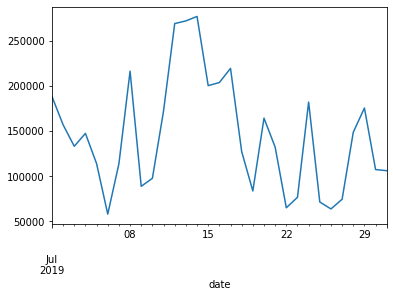

In [105]:
cleaned_logs['date'].dt.strftime('%d')
_ = cleaned_logs.groupby('date').size().sort_index(ascending=False).plot()

### Hits by Googlebot User Agent

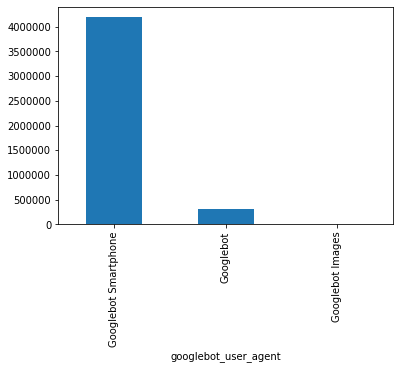

In [88]:
_ = cleaned_logs.groupby('googlebot_user_agent').size().sort_values(ascending=False).plot.bar()

### Top 10 Hit Site Sections by Googlebot

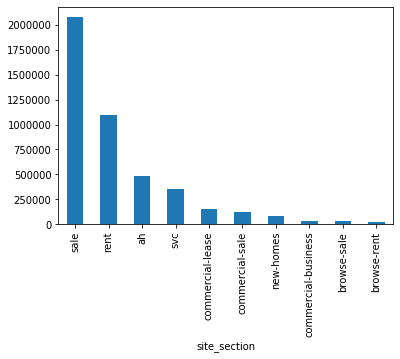

In [85]:
_ = cleaned_logs.groupby('site_section').size().sort_values(ascending=False).head(10).plot.bar()

### Hits by HTTP status range

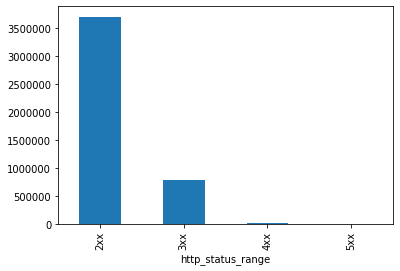

In [89]:
_ = cleaned_logs.groupby('http_status_range').size().sort_values(ascending=False).plot.bar()

### Real vs Fake Googlebot Hits

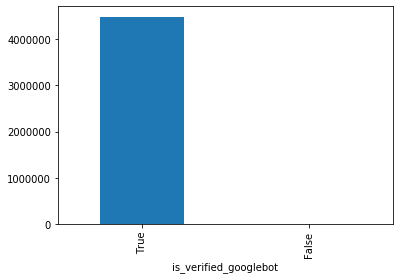

In [91]:
_ = cleaned_logs.groupby('is_verified_googlebot').size().sort_values(ascending=False).plot.bar()

### Parameter vs non-parameter hits

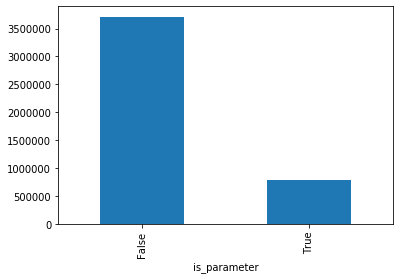

In [92]:
_ = cleaned_logs.groupby('is_parameter').size().sort_values(ascending=False).plot.bar()

### Top 10 parameters by Googlebot

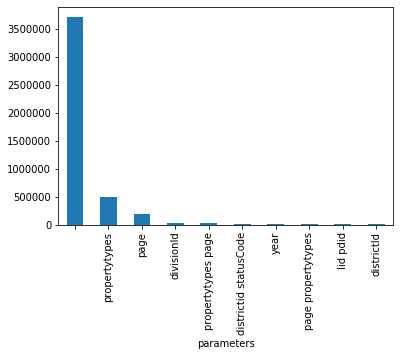

In [93]:
_ = cleaned_logs.groupby('parameters').size().sort_values(ascending=False).head(10).plot.bar()